In [1]:
import warnings
warnings.filterwarnings('ignore')
# import cv2
import numpy as np
import glob
from keras.models import load_model
import tensorflow as tf
from keras import optimizers
import keras
import segmentation_models as sm

import metric
from architecture import create_model, create_callbacks


BACKUP_MODEL_PATH = "./../Models/backup.h5"
seed = 56

IMAGE_HEIGHT = IMAGE_WIDTH = 256 * 2 # * 2

EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 4

ROOT = "./../Data/all-cities/"
TRAIN_DIR = "_Train512/"

Segmentation Models: using `keras` framework.


In [2]:
import get_data_generators

no_augmentation = {
"rotation_range": 0,
"width_shift_range": 0,
"height_shift_range": 0,
"fill_mode": "constant",
"cval": 0,
"horizontal_flip": "False",
"vertical_flip": "False",
"validation_split": 0.08
}

augmentation = {
"rotation_range": 90,
"width_shift_range": 0.1,
"height_shift_range": 0.1,
"fill_mode": "constant",
"cval": 0,
"horizontal_flip": "True",
"vertical_flip": "True",
"validation_split": 0.08
}

#augmentation = no_augmentation
train_gen, val_gen = get_data_generators.getDataGenerators(augmentation, (IMAGE_WIDTH, IMAGE_HEIGHT), ROOT + TRAIN_DIR + "Images", ROOT + TRAIN_DIR + "Masks", batch_size=BATCH_SIZE, seed=seed)

Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.


In [3]:
opt = keras.optimizers.Adam(LEARNING_RATE)
callbacks = create_callbacks(BACKUP_MODEL_PATH)

In [5]:
# """Load Model backup to resume training after crash or break or for pretraining"""
# model = load_model(BACKUP_MODEL_PATH, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.5), "f1-score":sm.metrics.FScore()})

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5e-06>


In [4]:
PRETRAINED_MODEL_PATH = "./../Models/Roads/road_mapper_scratch_x512_Combined_Train18598_Val1617_Test5079_No-Aug_IoU6065_f7516.h5"

model = load_model(PRETRAINED_MODEL_PATH, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.1), "f1-score":sm.metrics.FScore()})

first_half = ["conv2d_01","conv2d_02","conv2d_03","conv2d_04","conv2d_05","conv2d_06","conv2d_07","conv2d_08", "conv2d_09"]
second_half = ["conv2d_010","conv2d_011","conv2d_012","conv2d_013","conv2d_014","conv2d_015","conv2d_016","conv2d_017", "conv2d_018"]

for layer in model.layers:
      if layer.name in second_half:
            layer.trainable = False
      if layer.name in ["dropout", "dropout_1", "dropout_2", "dropout_3", "dropout_4", "dropout_5", "dropout_6", "dropout_7", "dropout_8"]:
            layer.rate = 2*layer.rate

#print(model.layers)
met = model.metrics[1:] + [metric.quality()] # [1:] to not include loss

model.compile(optimizer=opt, loss=model.loss, metrics= met, run_eagerly=True)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

history = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=EPOCHS, verbose=1) #,

Num GPUs Available:  1
Epoch 1/100
 42/901 [>.............................] - ETA: 3:22 - loss: 0.8345 - iou_score: 0.0918 - f1-score: 0.1655

KeyboardInterrupt: 

In [7]:
import datetime

print("Time of saving model:", datetime.datetime.now())

model_path = "./../Models/Binary/512/bike_mapper_pre-train-freeze-right-lr1e-4_double-dropout_Train3607_Val313_Test980_No-Aug.h5"
model.save(model_path)

Time of saving model: 2022-10-26 10:53:53.951043


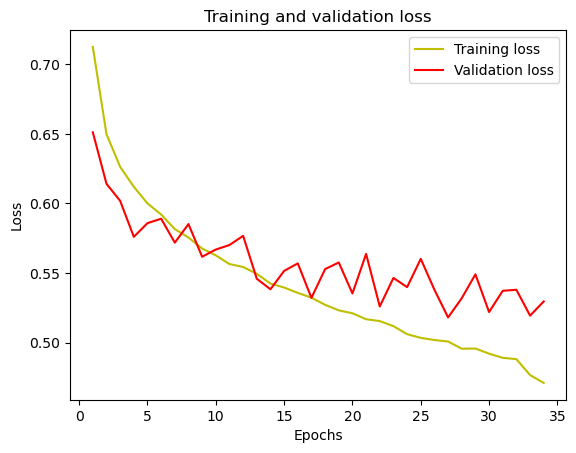

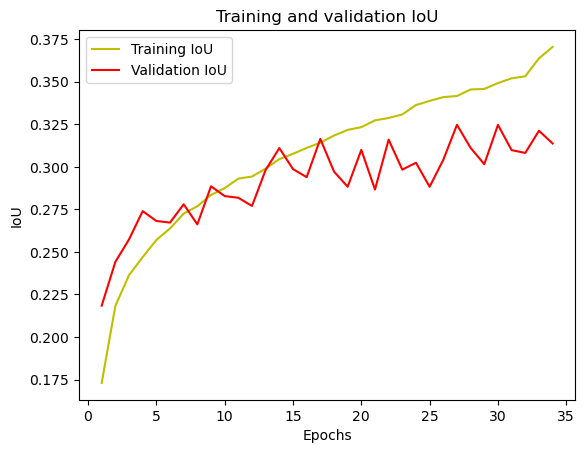

In [8]:
from matplotlib import pyplot as plt

loss = history.history['quality']
val_loss = history.history['val_quality']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Quality')
plt.plot(epochs, val_loss, 'r', label='Validation Quality')
plt.title('Training and validation quality')
plt.xlabel('Epochs')
plt.ylabel('Quality')
plt.legend()
plt.savefig(model_path[:-3] + "__quality.png")

plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.savefig(model_path[:-3] + "__iou.png")
plt.show()

Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Num GPUs Available:  1
Epoch 1/6
1935/1934 [==============================] - ETA: 0s - loss: 0.7233 - iou_score: 0.1646 - f1-score: 0.2766 - quality: 0.3767
Epoch 1: val_loss improved from inf to 0.66972, saving model to ./../Models\backup.h5
1934/1934 [==============================] - 506s 258ms/step - loss: 0.7233 - iou_score: 0.1646 - f1-score: 0.2766 - quality: 0.3767 - val_loss: 0.6697 - val_iou_score: 0.2024 - val_f1-score: 0.3303 - val_quality: 0.4419 - lr: 1.0000e-04
Epoch 2/6
1935/1934 [==============================] - ETA: 0s - loss: 0.6763 - iou_score: 0.1982 - f1-score: 0.3237 - quality: 0.4340
Epoch 2: val_loss improved from 0.66972 to 0.65166, saving model to ./../Models\backup.h5
1934/1934 [==============================] - 495s 256ms/step - loss: 0.6763 - iou_score: 0.1982 - f1-score: 0.3237 - quality: 0

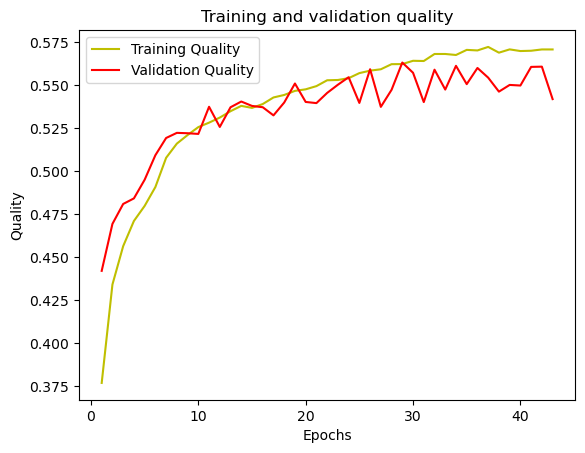

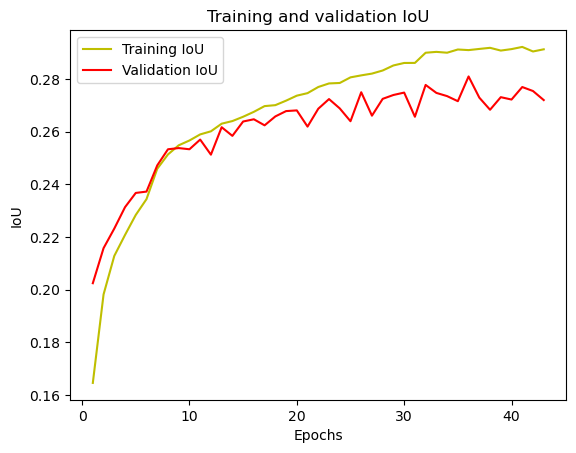

Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Num GPUs Available:  1
Epoch 1/6
1935/1934 [==============================] - ETA: 0s - loss: 0.6999 - iou_score: 0.1814 - f1-score: 0.3001 - quality: 0.3983
Epoch 1: val_loss improved from inf to 0.65393, saving model to ./../Models\backup.h5
1934/1934 [==============================] - 499s 258ms/step - loss: 0.6999 - iou_score: 0.1814 - f1-score: 0.3001 - quality: 0.3983 - val_loss: 0.6539 - val_iou_score: 0.2152 - val_f1-score: 0.3461 - val_quality: 0.4644 - lr: 1.0000e-04
Epoch 2/6
1935/1934 [==============================] - ETA: 0s - loss: 0.6461 - iou_score: 0.2212 - f1-score: 0.3539 - quality: 0.4643
Epoch 2: val_loss improved from 0.65393 to 0.63903, saving model to ./../Models\backup.h5
1934/1934 [==============================] - 498s 258ms/step - loss: 0.6461 - iou_score: 0.2212 - f1-score: 0.3539 - quality: 0

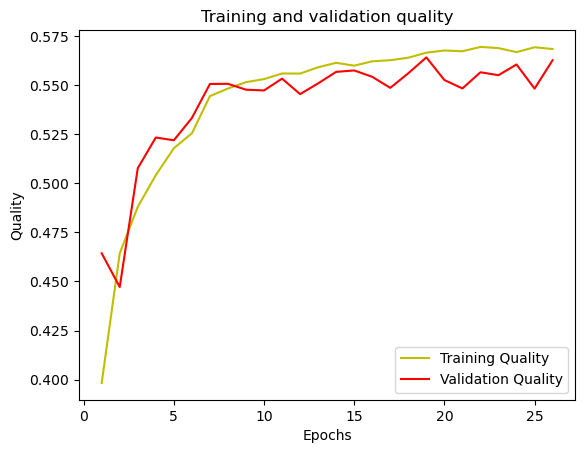

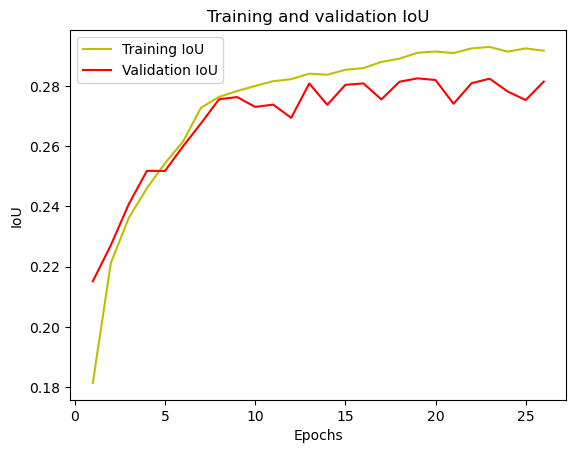

In [4]:
PRETRAINED_MODEL_PATH = "./../Models/Roads/road_mapper_scratch_x512_Combined_Train18598_Val1617_Test5079_No-Aug_IoU6065_f7516.h5"

first_half = (["conv2d_01","conv2d_02","conv2d_03","conv2d_04","conv2d_05","conv2d_06","conv2d_07","conv2d_08", "conv2d_09"], "freeze-left")
second_half = (["conv2d_010","conv2d_011","conv2d_012","conv2d_013","conv2d_014","conv2d_015","conv2d_016","conv2d_017", "conv2d_018"], "freeze-right")

halves = [first_half, second_half]

for half in halves:

      train_gen, val_gen = get_data_generators.getDataGenerators(augmentation, (IMAGE_WIDTH, IMAGE_HEIGHT), ROOT + TRAIN_DIR + "Images", ROOT + TRAIN_DIR + "Masks", batch_size=BATCH_SIZE, seed=seed)

      # define model
      model = load_model(PRETRAINED_MODEL_PATH, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.1), "f1-score":sm.metrics.FScore()})

      nb_train_false = 0
      for layer in model.layers:
          if layer.name in half[0]:
                layer.trainable = False
                nb_train_false += 1

            # if layer.name in ["dropout", "dropout_1", "dropout_2", "dropout_3", "dropout_4", "dropout_5", "dropout_6", "dropout_7", "dropout_8"]:
            #       layer.rate = 2*layer.rate
      if nb_train_false < 5:
          print("could only freeze", nb_train_false, "layers")
          raise Exception

      opt = keras.optimizers.Adam(LEARNING_RATE)
      callbacks = create_callbacks(BACKUP_MODEL_PATH)

      met = model.metrics[1:] + [metric.quality()] # [1:] to not include loss

      model.compile(optimizer=opt, loss=model.loss, metrics= met, run_eagerly=True)

      print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

      history1 = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=6, verbose=1)

      for layer in model.layers:
            layer.trainable = True


      opt = model.optimizer
      opt.lr = LEARNING_RATE / 10

      model.compile(
        optimizer=opt,
        loss=sm.losses.DiceLoss(),
        metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True
      )

      history = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=EPOCHS, verbose=1) #,

      keys = ['quality', 'iou_score', 'val_iou_score', 'val_quality']
      for key in keys:
            history.history[key] = history1.history[key] + history.history[key]

      import datetime

      print("Time of saving model:", datetime.datetime.now())

      model_path = "./../Models/Double-Data/pre-train/bike_mapper_pre-train-" + half[1] + "_No-Aug.h5"
      model.save(model_path)

      from matplotlib import pyplot as plt

      loss = history.history['quality']
      val_loss = history.history['val_quality']
      epochs = range(1, len(loss) + 1)
      plt.plot(epochs, loss, 'y', label='Training Quality')
      plt.plot(epochs, val_loss, 'r', label='Validation Quality')
      plt.title('Training and validation quality')
      plt.xlabel('Epochs')
      plt.ylabel('Quality')
      plt.legend()
      plt.savefig(model_path[:-3] + "__quality.png")

      plt.show()

      acc = history.history['iou_score']
      val_acc = history.history['val_iou_score']

      plt.plot(epochs, acc, 'y', label='Training IoU')
      plt.plot(epochs, val_acc, 'r', label='Validation IoU')
      plt.title('Training and validation IoU')
      plt.xlabel('Epochs')
      plt.ylabel('IoU')
      plt.legend()
      plt.savefig(model_path[:-3] + "__iou.png")
      plt.show()




#print(model.layers)


